In [276]:
import numpy as np
import os
os.chdir('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/')
import argparse
import utils as autils
from utils import DUST_TYPES
from orphics import cosmology
import pyfisher
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

In [21]:
dict_plot = {}
dict_plot['GAL040'] = {'linestyle': 'dotted', 'label': 'ACT 40\%'}
dict_plot['GAL060'] = {'linestyle': 'dashed', 'label': 'ACT 60\%'}
dict_plot['GAL070'] = {'linestyle': 'solid', 'label': 'ACT 70\%'}
dict_plot['GAL080'] = {'linestyle': 'dotted', 'label': 'ACT 80\%'}

dict_plot['lmin100'] = {'linestyle': 'dotted', 'label': r'$\ell_{\textrm{min}} = 100$'}
dict_plot['lmin1000'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{min}} = 1000$'}
dict_plot['lmin600'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{min}} = 600$'}
dict_plot['lmax3000'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{max}} = 3000$'}
dict_plot['lmax3500'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{max}} = 3500$'}

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

dict_plot['gauss'] = {'color': colors[0], 'label': 'Gaussian field'}
dict_plot['d9'] = {'color': colors[1], 'label': 'PySM d9'}
dict_plot['d10'] = {'color': colors[2], 'label': 'PySM d10'}
dict_plot['d12'] = {'color': colors[3], 'label': 'PySM d12'}
dict_plot['DF'] = {'color': colors[4], 'label': 'DUSTFILAMENTS'}
dict_plot['van'] = {'color': colors[5], 'label': 'Vansyngel+17'}

In [268]:
args = argparse.Namespace()

args.mlmax=4000

args.width_ra=15
args.width_dec=10

# args.lmax=3000
# args.lmin=600
args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4

args.nsims_mf=50

args.est= 'TT'
args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'

In [34]:
# # signal
# lk, clkk=np.loadtxt('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/sslp/extra/clkk_raw_plikHM_TTTEEE_lowl_lowE_dr6_accuracy.txt',unpack=True)
# clpp = clkk * 4 / (lk * (lk+1))**2

/tmp/ipykernel_1225155/621840297.py:3: RuntimeWarning: invalid value encountered in divide
  clpp = clkk * 4 / (lk * (lk+1))**2


In [317]:
ells = np.arange(args.mlmax+1)
theory = cosmology.default_theory()
clkk = theory.gCl('kk',ells)
clpp = clkk * 4 / (ells * (ells+1))**2
clpp[0]=0.

/tmp/ipykernel_1225155/1019925388.py:4: RuntimeWarning: invalid value encountered in divide
  clpp = clkk * 4 / (ells * (ells+1))**2


In [68]:
# plt.loglog(nclkk * 4 / (ells * (ells+1))**2*lfac)
# plt.loglog(clpp[:args.mlmax+1]*lfac)

In [284]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
lcut = 50
nbands_log = 20
nbands_lin = 5
lbands = np.concatenate((np.linspace(2, lcut, nbands_lin, dtype=int)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands_log+1, dtype=int)))#  dtype=int)
nbands = len(lbands)-1
leff = (lbands[1:] + lbands[:-1])/2. # [np.mean(np.arange(x,y)) for x,y in zip(lbands[:-1], lbands[1:])]

In [285]:
windows_log = np.zeros([nbands, args.mlmax+1])

cl_weights = np.ones_like(ell_arr)

for b_i,(b_l0,b_lf) in enumerate(zip(lbands[:-1],lbands[1:])):

    if weight == 'LFAC':
        windows_log[b_i,b_l0:b_lf] = ((ell_arr * (ell_arr + 1))**2/(2*np.pi))[b_l0:b_lf]
    if weight == 'Cl':
        windows_log[b_i, b_l0:b_lf] = cl_weights[b_l0:b_lf]

    windows_log[b_i,:] /= np.diff(lbands)[b_i]

In [322]:
windows_kk = np.zeros([nbands, args.mlmax+1])

cl_weights = np.ones_like(ell_arr)

for b_i,(b_l0,b_lf) in enumerate(zip(lbands[:-1],lbands[1:])):

#     if weight == 'LFAC':
#         windows_log[b_i,b_l0:b_lf] = ((ell_arr * (ell_arr + 1))**2/(2*np.pi))[b_l0:b_lf]
#     if weight == 'Cl':
    windows_kk[b_i, b_l0:b_lf] = cl_weights[b_l0:b_lf]

    windows_kk[b_i,:] /= np.diff(lbands)[b_i]

In [286]:
LMIN = 2
DELL = 20
LMAX = args.mlmax
NBANDS = int((LMAX - LMIN)/DELL)
LARR_ALL = np.arange(LMAX+1)
LBANDS = np.linspace(LMIN, LMAX, NBANDS+1,dtype=int)
weight = 'LFAC'
LEFF = (LBANDS[1:] + LBANDS[:-1]) / 2. # [np.mean(np.arange(x,y)) for x,y in zip(LBANDS[:-1], LBANDS[1:])]
LFAC = ( LARR_ALL * (LARR_ALL+1) )**2 / (2 * np.pi)

In [287]:
windows = np.zeros([NBANDS,LMAX+1])

cl_weights = np.ones_like(LARR_ALL)

for b_i,(b_l0,b_lf) in enumerate(zip(LBANDS[:-1],LBANDS[1:])):

    if weight == 'LFAC':
        windows[b_i,b_l0:b_lf] = ((LARR_ALL * (LARR_ALL + 1))**2/(2*np.pi))[b_l0:b_lf]
    if weight == 'Cl':
        windows[b_i, b_l0:b_lf] = cl_weights[b_l0:b_lf]

    windows[b_i,:] /= DELL

In [313]:
windows_kk = np.zeros([NBANDS,LMAX+1])

cl_weights = np.ones_like(LARR_ALL)

for b_i,(b_l0,b_lf) in enumerate(zip(LBANDS[:-1],LBANDS[1:])):

#     if weight == 'LFAC':
#         windows[b_i,b_l0:b_lf] = ((LARR_ALL * (LARR_ALL + 1))**2/(2*np.pi))[b_l0:b_lf]
#     if weight == 'Cl':
    windows_kk[b_i, b_l0:b_lf] = cl_weights[b_l0:b_lf]

    windows_kk[b_i,:] /= DELL

In [288]:
clpp_bin = windows@clpp[:LMAX+1]
clpp_bin_log = windows_log@clpp[:LMAX+1]

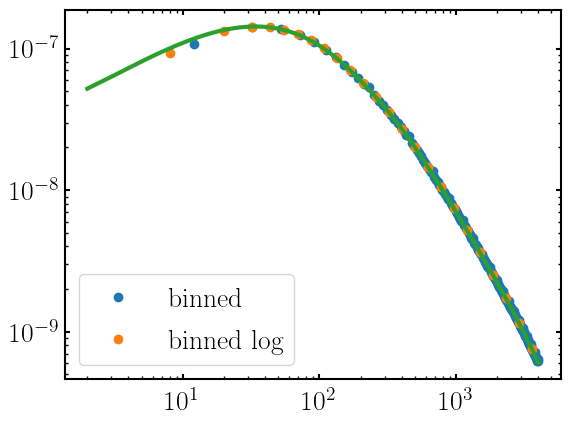

In [289]:

plt.loglog(LEFF, clpp_bin, 'o',label='binned')
plt.loglog(leff, clpp_bin_log, 'o',label='binned log')
plt.loglog(LARR_ALL[2:], (clpp * LFAC)[2:], lw=3)
plt.legend()

In [290]:
# ok great, this wokrs

In [291]:
f'{dust_type}_{SKYFRAC}_{TEST}'

'DF_GAL080_baseline'

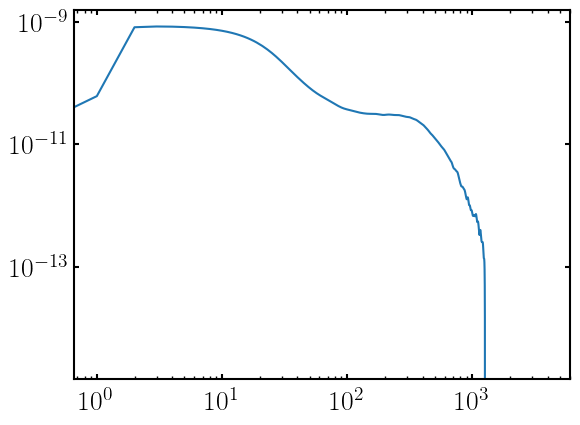

In [292]:
plt.loglog(reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)

In [293]:
reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][0] = 0

In [294]:
clpp_dust_bin = windows@reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:LMAX+1]
clpp_dust_bin_log = windows_log@reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:LMAX+1]

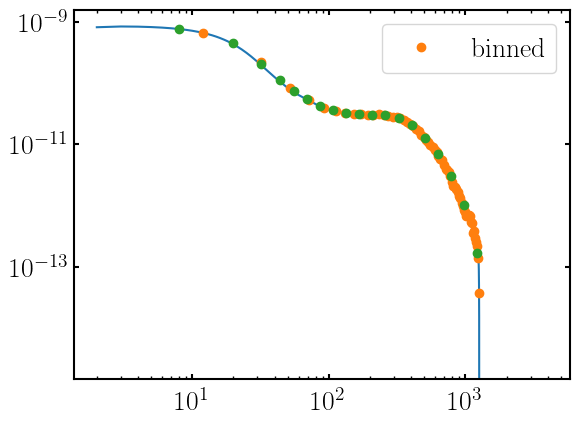

In [295]:
plt.loglog(LARR_ALL[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1] * LFAC)[2:])
plt.loglog(LEFF, clpp_dust_bin, 'o',label='binned')
plt.loglog(leff, clpp_dust_bin_log,'o')
plt.legend()

In [262]:
# delta aLENS
baseline_path = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'

In [263]:
# load filters
Als = np.load(baseline_path + f'stage_compute_filters/{autils.get_norm_name(args)}', allow_pickle=True).item()

In [266]:
Als['TT'][0]

array([0.00000000e+00, 1.58710141e-07, 1.10722290e-08, ...,
       2.17339659e-20, 2.17473899e-20, 2.17608850e-20])

In [270]:
Nl =Als[args.est][0] * (ells*(ells+1.)/2.)**2.

In [296]:
cents, bins = pyfisher.get_binner(lbands,interpolate=False)

In [301]:
delta_ell = np.diff(lbands)

In [303]:
fsky = 0.03

In [323]:
clkk_bin = windows_kk@clkk[:LMAX+1]

In [319]:
tclkk = theory.gCl('kk',ells)
cls={'kk': pyfisher.interp(ells, tclkk, bounds_error=True)}
tclkk_bin = bins(cls['kk'])

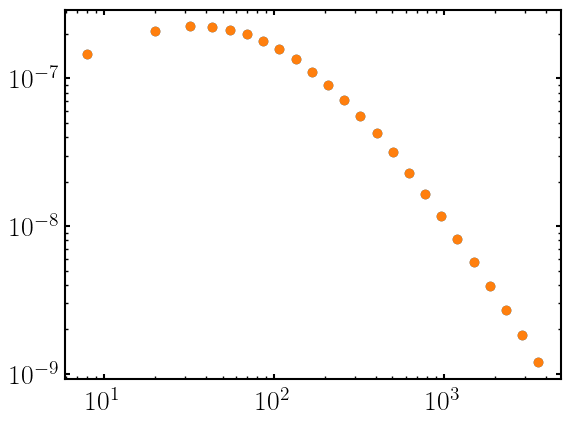

In [324]:
plt.loglog(cents,tclkk_bin,'o')
plt.loglog(leff, clkk_bin,'o')

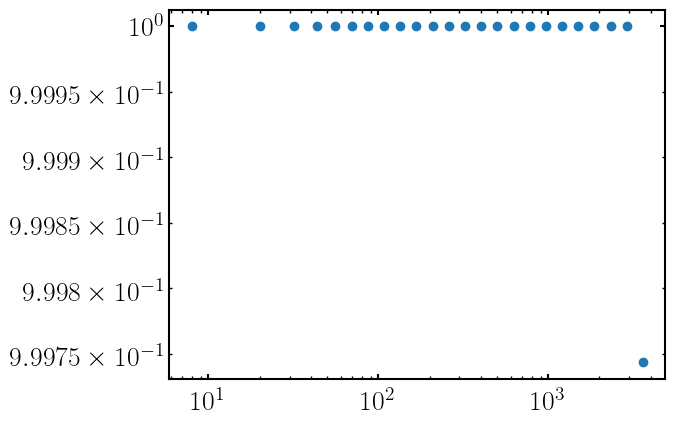

In [326]:
plt.loglog(cents,tclkk_bin/clkk_bin,'o')
#plt.loglog(leff, clkk_bin,'o')

In [ ]:

plt.loglog(LEFF, clpp_bin, 'o',label='binned')
plt.loglog(leff, clpp_bin_log, 'o',label='binned log')
plt.loglog(LARR_ALL[2:], (clpp * LFAC)[2:], lw=3)
plt.legend()

In [327]:
nls_dict = {'kk':pyfisher.interp(ells,Nl,bounds_error=True)}
nls_kk_bin = bins(nls_dict['kk'])

In [328]:
covariance_factor = 1/(delta_ell*fsky*(2*cents+1))
covariance = 2 * (clkk_bin + nls_kk_bin)**2 * covariance_factor

In [ ]:
def my_snr_knox(est1, bin_edges, fsky, interpolate=False):

    # my own knox formula:
    cents,bin = pyfisher.get_binner(bin_edges,interpolate)
    delta_ell = np.diff(bin_edges)
    clkk = theory.gCl('kk',ells)
    cls={'kk': pyfisher.interp(ells, clkk, bounds_error=True)}
    clkk_bin = bin(cls['kk'])
    Nl =Als[est1][0] * (ells*(ells+1.)/2.)**2.
    nls_dict = {'kk':pyfisher.interp(ells,Nl,bounds_error=True)}
    nls_kk_bin = bin(nls_dict['kk'])
    covariance_factor = 1/(delta_ell*fsky*(2*cents+1))
    covariance = 2 * (clkk_bin + nls_kk_bin)**2 * covariance_factor
    inv_cov = 1/covariance
    return np.sqrt(sum(clkk_bin* (inv_cov*clkk_bin)))

In [331]:
1/np.sqrt(sum(clkk_bin**2 / covariance))*100

3.727987345903986

In [6]:
npatches = {}
for skyfrac in autils.FSKYS:
    npatches[skyfrac] = np.load(args.output_dir + f'local_masks/submap_coordinates_{skyfrac}_{args.width_ra}_{args.width_dec}.npy').shape[0]
print(npatches)

{'GAL060': 111, 'GAL070': 118, 'GAL080': 133}


In [7]:
def args_baseline(args, skyfrac, dust_type):
    
    args.lmax=3000
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

def args_lmin(args, lmin, dust_type, skyfrac='GAL070'):
    
    args.lmax=3000
    args.lmin=lmin
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

def args_lmax(args, lmax, dust_type, skyfrac='GAL070'):
    
    args.lmax=lmax
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=90.
    args.skyfrac=skyfrac
    
    return args

In [8]:
path_recons = lambda ipatch, args, tag, mf: args.output_dir + f'stage_reconstruction/{autils.get_recons_name(ipatch, args, tag, mf)}'

In [9]:
raw_4pt = {}
rawmf_4pt = {}
n0_4pt = {}
reconstructed_cl = {}
cl_nobias = {}

for skyfrac in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        for test in ['baseline', 'lmin', 'lmax']:
            
            raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [10]:
TEST='baseline'

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=False))
            rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=True))
            n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'N0', mf=False))

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for SKYFRAC in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_1225155/4174546873.py:17: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [17]:
skyfrac='GAL070'

test='lmin100'

for dust_type in autils.DUST_TYPES:
         
    raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
    rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
    n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
    cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [18]:
SKYFRAC = 'GAL070'
TEST='lmin100'
lmin=100

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=False))
        rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=True))
        n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'N0', mf=False))

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for dust_type in autils.DUST_TYPES:
    reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_1225155/2019538268.py:16: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [12]:
SKYFRAC = 'GAL070'
TEST='lmin'
lmin=1000

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=False))
        rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=True))
        n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'N0', mf=False))

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for dust_type in autils.DUST_TYPES:
    reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_1225155/2178258001.py:16: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [13]:
SKYFRAC = 'GAL070'
TEST='lmax'
lmax=3500

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=False))
        rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=True))
        n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'N0', mf=False))

for n in range(npatches[SKYFRAC]):
    for dust_type in autils.DUST_TYPES:
        cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for dust_type in autils.DUST_TYPES:
    reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_1225155/1533567561.py:16: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


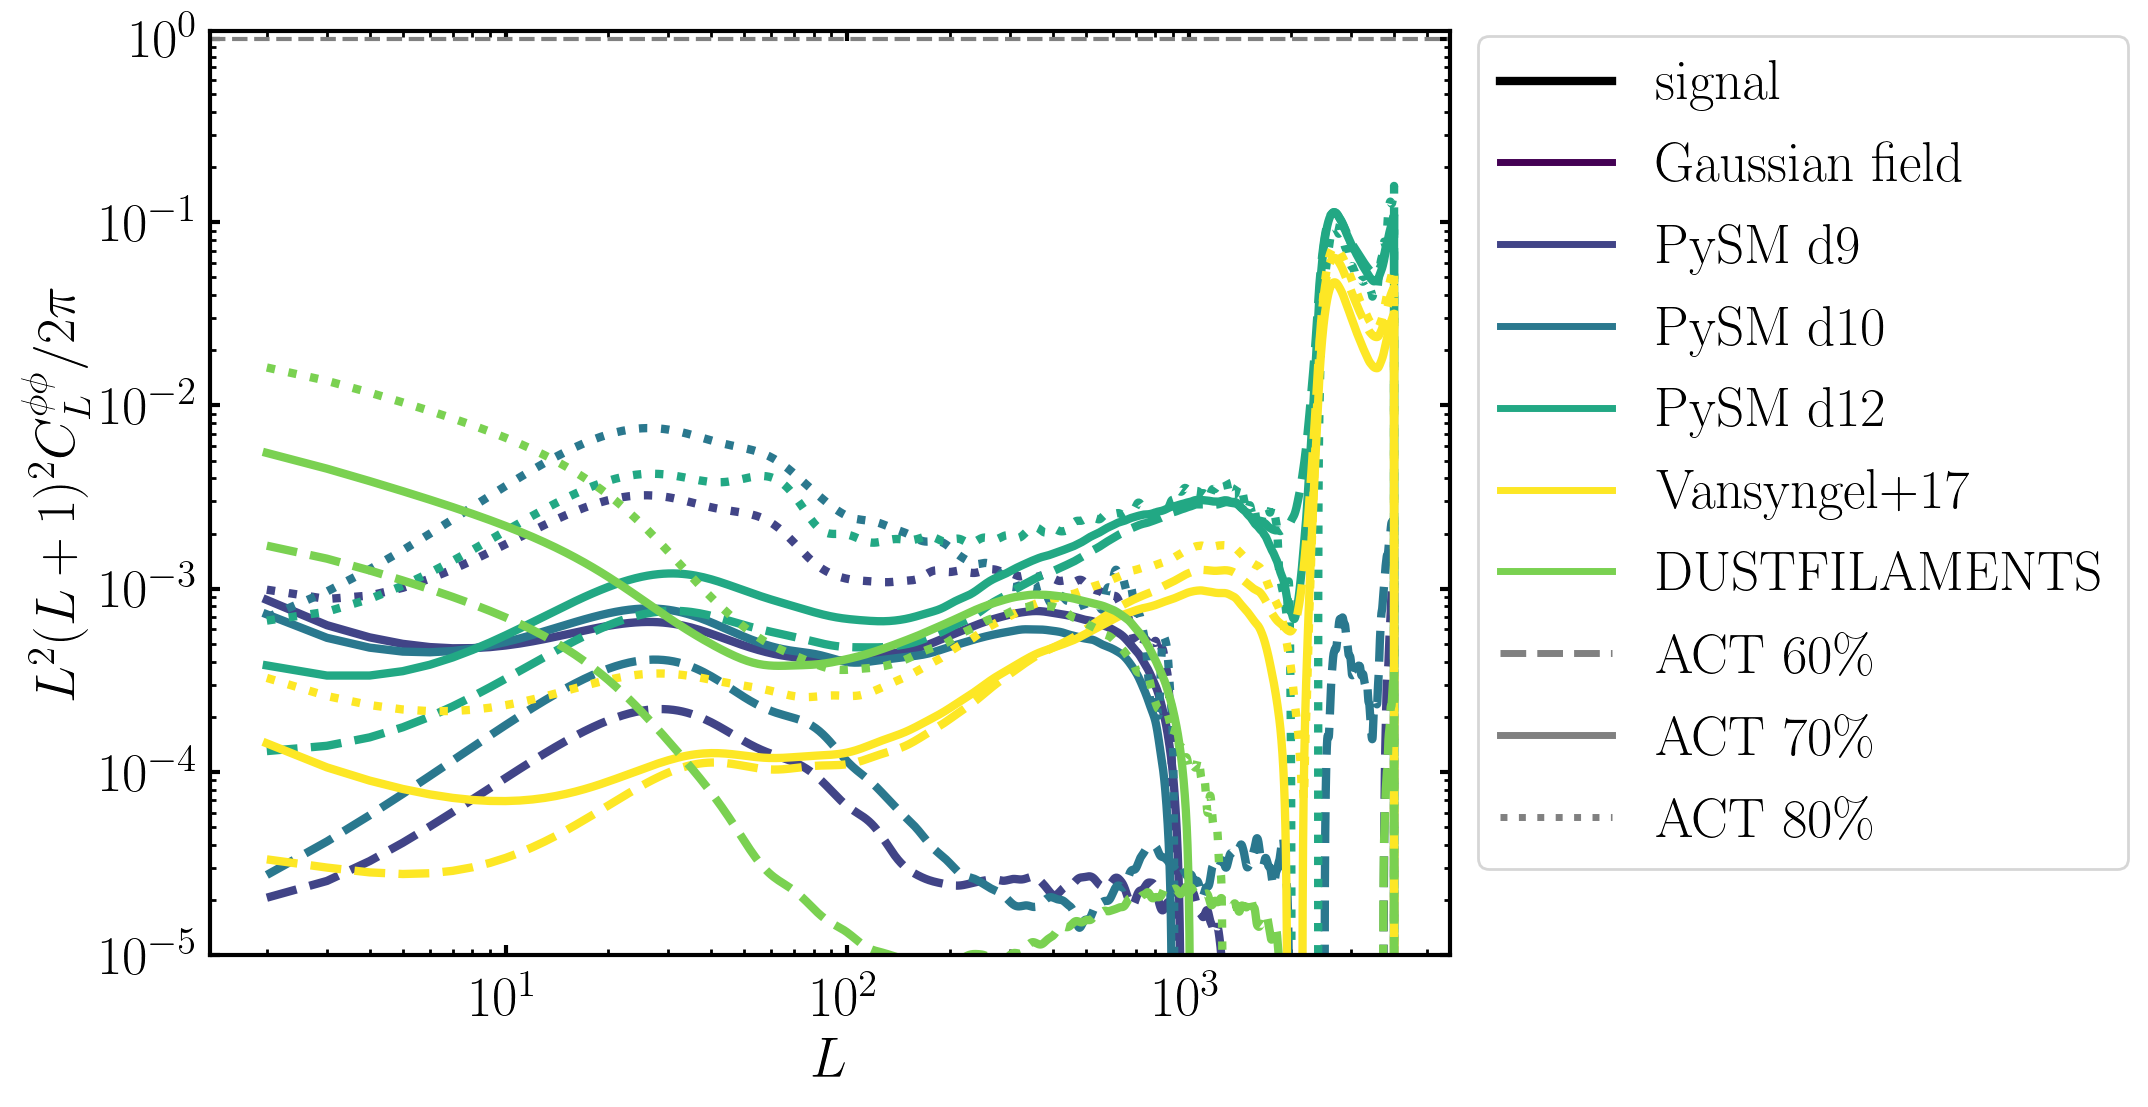

In [30]:
TEST='baseline'
SKYFRAC = 'GAL060'
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

#ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        ax.loglog(ell_arr[2:], (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)[2:] / (clpp[:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)

    
custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[GAL]['linestyle'], lw=2.5) for GAL in autils.FSKYS]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES]
legend_lines3 = [dict_plot[GAL]['label'] for GAL in autils.FSKYS]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.025), loc = 'upper left') # (1, 1.025)
ax.set_ylim(1e-5,1.1)
ax.axhline(1, linestyle='dashed', color='gray')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')

####fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/recons_baseline_skyfrac.png', bbox_inches='tight')
plt.show()

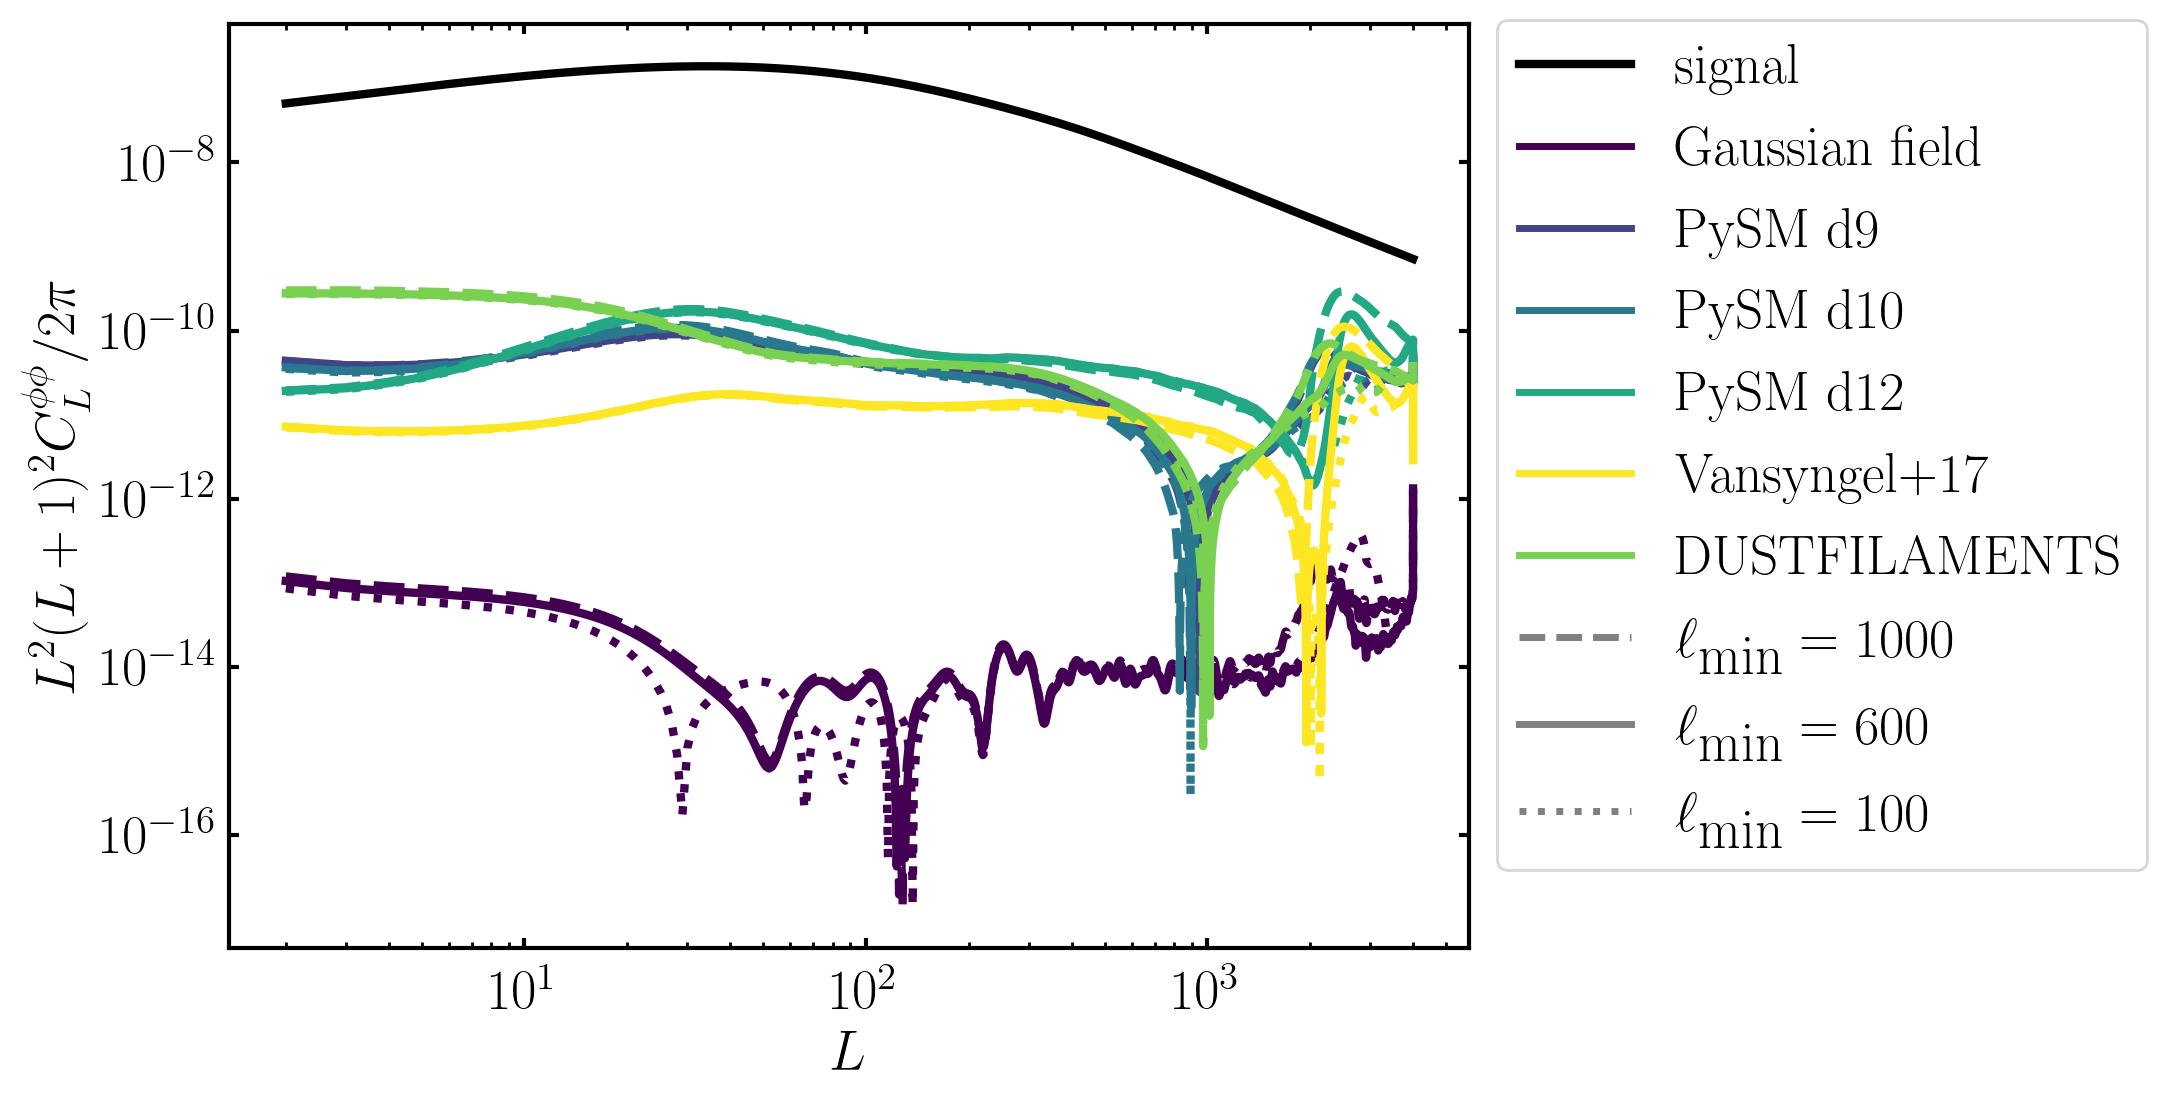

In [23]:
SKYFRAC='GAL070'
#TEST = 'lmin'
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

for dust_type in autils.DUST_TYPES:
    
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_lmin'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmin1000']['linestyle'], linewidth = 3, label=dust_type)
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmin600']['linestyle'], linewidth = 3, label=dust_type)
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_lmin100'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmin100']['linestyle'], linewidth = 3, label=dust_type)
    

ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[f'lmin{lmin}']['linestyle'], lw=2.5) for lmin in [1000,600,100]]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES]
legend_lines3 = [dict_plot[f'lmin{lmin}']['label'] for lmin in [1000, 600,100]]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.035), loc = 'upper left') # (1, 1.025)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$') 

####fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/recons_baseline_lmax.png', bbox_inches='tight')

plt.show()

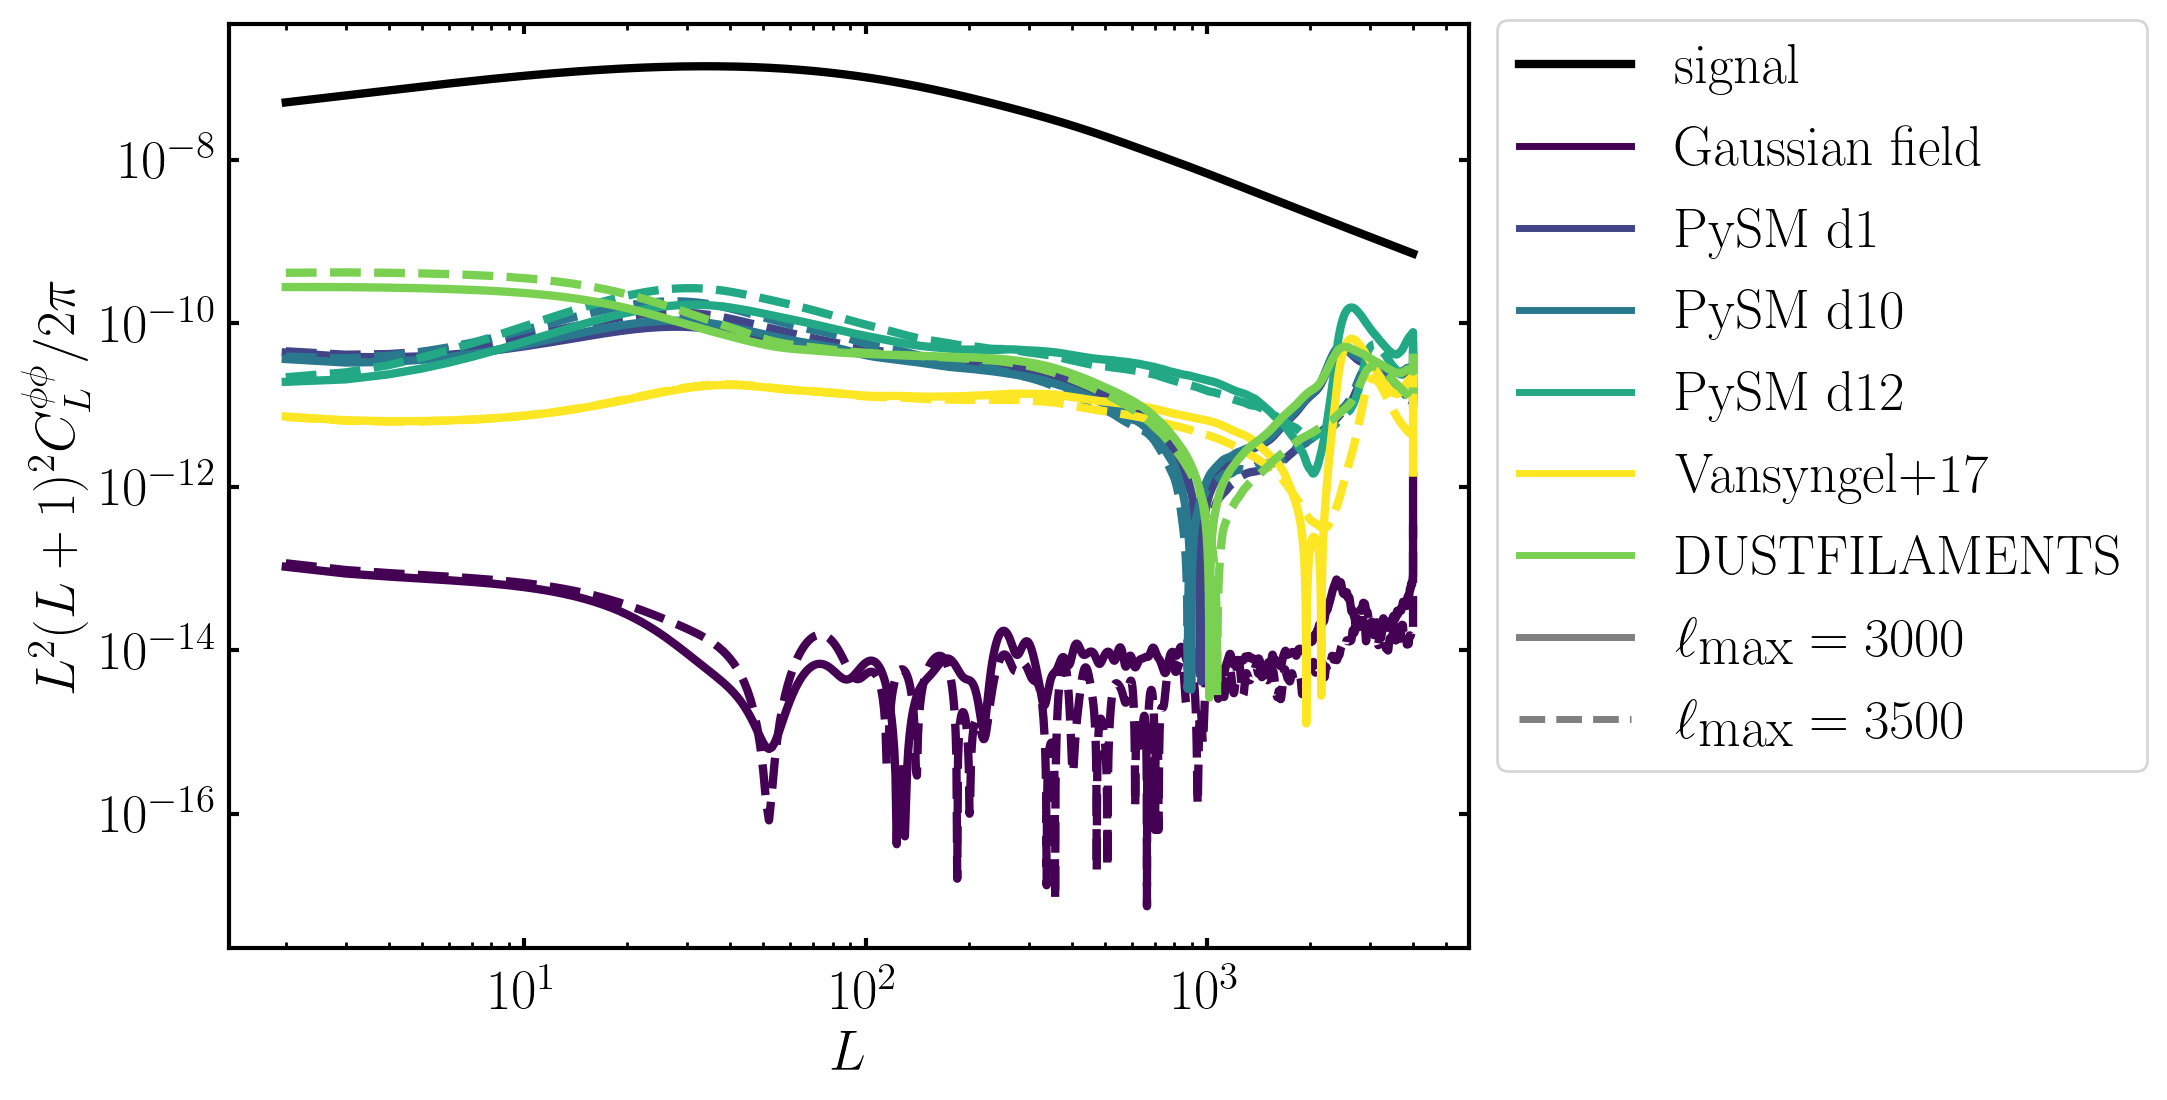

In [46]:
SKYFRAC='GAL070'
TEST = 'lmax'
fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

for dust_type in autils.DUST_TYPES:
    
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmax3500']['linestyle'], linewidth = 3, label=dust_type)
    ax.loglog(ell_arr[2:], abs(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'][:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot['lmax3000']['linestyle'], linewidth = 3, label=dust_type)


ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[f'lmax{lmax}']['linestyle'], lw=2.5) for lmax in [3000, 3500]]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES]
legend_lines3 = [dict_plot[f'lmax{lmax}']['label'] for lmax in [3000, 3500]]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.035), loc = 'upper left') # (1, 1.025)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$') 

####fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/recons_baseline_lmax.png', bbox_inches='tight')

plt.show()